Importing Libraries

In [ ]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
import pickle

Load dataset

In [ ]:
file_path = "/content/zomato_reviews.csv"
df = pd.read_csv(file_path)
df.drop(columns=['Unnamed: 0'], inplace=True)

# Drop missing values

In [ ]:

df.dropna(inplace=True)


# Convert ratings to sentiment labels (1-2: Negative, 3: Neutral, 4-5: Positive)

In [ ]:

def categorize_rating(rating):
    if rating <= 2:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    else:
        return "Positive"

df['sentiment'] = df['rating'].apply(categorize_rating)

# Data Cleaning

In [ ]:

nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = word_tokenize(text)  # Tokenization
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    return ' '.join(text)

df['cleaned_review'] = df['review'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Encode Sentiment Labels

In [ ]:

label_encoder = LabelEncoder()
df['sentiment_label'] = label_encoder.fit_transform(df['sentiment'])  # Convert labels to numbers


# Train-Test Split

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(df['cleaned_review'], df['sentiment_label'], test_size=0.2, random_state=42)



# Convert Text to Numeric

In [ ]:

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# Train Logistic Regression Model with Hyperparameter Tuning

In [ ]:

rf_params = {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy')
rf_grid.fit(X_train_tfidf, y_train)
y_pred_rf = rf_grid.best_estimator_.predict(X_test_tfidf)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Best Random Forest Accuracy:", rf_accuracy)
print("Best Random Forest Model:", rf_grid.best_estimator_)


Best Random Forest Accuracy: 0.5027372262773723
Best Random Forest Model: RandomForestClassifier(max_depth=20, n_estimators=200, random_state=42)


# Train LSTM Model with Hyperparameter Tuning
# Tokenize Text

In [ ]:

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=100)
X_test_pad = pad_sequences(X_test_seq, maxlen=100)

# Define LSTM Model with Dropout and Learning Rate Tuning

In [ ]:

lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=100),
    LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2),
    LSTM(32, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


# Train Model

In [ ]:

lstm_model.fit(X_train_pad, y_train, epochs=10, batch_size=32, validation_data=(X_test_pad, y_test))

Epoch 1/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 37s 265ms/step - accuracy: 0.0855 - loss: -50.2911 - val_accuracy: 0.0958 - val_loss: -52.6590
Epoch 2/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 44s 291ms/step - accuracy: 0.0849 - loss: -19.7593 - val_accuracy: 0.0958 - val_loss: -57.3850
Epoch 3/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 275ms/step - accuracy: 0.0808 - loss: -59.2739 - val_accuracy: 0.1104 - val_loss: -60.2376
Epoch 4/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 48s 352ms/step - accuracy: 0.2022 - loss: -160.8841 - val_accuracy: 0.1496 - val_loss: -82.2122
Epoch 5/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 68s 252ms/step - accuracy: 0.2557 - loss: -260.2241 - val_accuracy: 0.1661 - val_loss: -121.7515
Epoch 6/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 33s 241ms/step - accuracy: 0.2593 - loss: -423.1528 - val_accuracy: 0.1971 - val_loss: -155.1573
Epoch 7/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 36s 265ms/step - accuracy: 0.2877 - loss: -560.4877 - val_accuracy: 0.1898 - val_loss: -211.6568
Epoch 8/10
137/137 ━━━━━━━━━━━━━━━━━━━━ 39s 252m

# Evaluate LSTM Model

In [ ]:

y_pred_lstm = (lstm_model.predict(X_test_pad) > 0.5).astype("int32")
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
print("LSTM Accuracy:", lstm_accuracy)
print("LSTM Model Summary:")
lstm_model.summary()


35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step
LSTM Accuracy: 0.33394160583941607
LSTM Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (32, 100, 128)              │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (32, 100, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (32, 32)                    │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (32, 32)                    │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 32)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (32, 1)                     │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 702,913 (2.68 MB)

 Trainable params: 702,913 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

# Plot Model

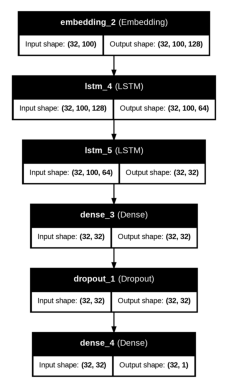

In [ ]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.utils import plot_model #Import plot_model from tensorflow

plot_model(lstm_model, to_file='lstm_model_plot.png', show_shapes=True, show_layer_names=True)

# ... (Rest of your code) ...
import matplotlib.pyplot as plt #Import the pyplot module

plt.imshow(plt.imread('lstm_model_plot.png'))
plt.axis('off')
plt.show()

# Save Models

In [ ]:

pickle.dump(lr_grid.best_estimator_, open('logistic_regression.pkl', 'wb'))
pickle.dump(rf_grid.best_estimator_, open('random_forest.pkl', 'wb'))
lstm_model.save('lstm_model.h5')